In [129]:
import os
from datetime import datetime
from tqdm import notebook
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

from constants import DATA_DIR, SEASONS
from scoring_utils import PLAYER_SCORE, normal_round

from collections import Counter

pd.set_option('display.max_columns', 500)

# Table of Contents

* [Scoring System](#ScoringSystem)
    * [Check if scoring matches dunkest dataframe](#SCompare)
    * [Generate scores for each year](#SGenerate)
   
   
* [Generate player averages dataset](#PAvg)


* [Generate individual players' dataset](#PInd)


* [Create single boxscore dataframe](#Boxscore)

# Scoring System <a class="anchor" id="ScoringSystem"></a>

*EXPLAIN HOW!*

In [155]:
def get_player_score(row):
    out = 0
    for func in PLAYER_SCORE.keys():
        out += PLAYER_SCORE[func](row)
    return normal_round(out, 1)

def get_player_score_nowin(row):
    out = 0
    for func in PLAYER_SCORE.keys():
        if func == 'WIN':
            continue
        out += PLAYER_SCORE[func](row)
    return normal_round(out, 1)

## Check if scoring matches dunkest dataframe <a class="anchor" id="SCompare"></a>

In [156]:
%%script false --no-raise-error

dunkest_df = pd.read_csv(f'{DATA_DIR}/Credits/dunkest.csv', low_memory=False)

dunkest_df.drop(['TEAM', 'DATE', 'MP', 'FG_perc', '3P_perc', 'FT_perc', '+/-', 'WEEK', 'CR', 'PLUS'], axis=1, inplace=True)

dunkest_df['COMPUTED_PDK'] = dunkest_df.apply(get_player_score_nowin, axis=1)

dunkest_df['PDK_WIN'] = dunkest_df.apply(lambda x: x.COMPUTED_PDK + 3, axis=1)
dunkest_df['PDK_LOSS'] = dunkest_df.apply(lambda x: x.COMPUTED_PDK - 3, axis=1)

dunkest_df['CHECK_WIN'] = dunkest_df.apply(lambda x: x.PDK == x.PDK_WIN, axis=1)
dunkest_df['CHECK_LOSS'] = dunkest_df.apply(lambda x: x.PDK == x.PDK_LOSS, axis=1)

dunkest_df['CHECK_PDK_with_win_score'] = dunkest_df.apply(lambda x: any([x.CHECK_WIN, x.CHECK_LOSS]), axis=1)
dunkest_df['CHECK_PDK_no_win_score'] = dunkest_df.apply(lambda x: x.PDK == x.COMPUTED_PDK, axis=1)
dunkest_df['CHECK_any_PDK'] = dunkest_df.apply(lambda x: any([x.CHECK_PDK_with_win_score, x.CHECK_PDK_no_win_score]), axis=1)

dunkest_df.to_csv(f'{DATA_DIR}/Credits/dunkest_pdk_analysis.csv', index_label=False)

In [157]:
pdk_df = pd.read_csv(f'{DATA_DIR}/Credits/dunkest_pdk_analysis.csv')

#### Check if either 'with WIN' or 'without WIN' match the original PDK

In [158]:
values = pdk_df.CHECK_any_PDK.value_counts()
print(f'There are {values[True]} rows for which PDK matches, but also {values[False]} for which it does not! Why?')

There are 54199 rows for which PDK matches, but also 10840 for which it does not! Why?


In [159]:
wrong_pdk_df = pdk_df.loc[pdk_df.CHECK_any_PDK==False]

differences = Counter(round(wrong_pdk_df.PDK - wrong_pdk_df.COMPUTED_PDK, 1))
differences = dict(sorted(differences.items(), key=lambda x: x[0]))

differences

{-13.0: 4,
 -12.0: 13,
 -11.0: 12,
 -8.0: 915,
 -7.1: 2,
 -7.0: 1164,
 -6.1: 5,
 -6.0: 2468,
 -5.0: 33,
 -4.0: 4,
 -3.1: 758,
 -3.0: 2243,
 -2.0: 1499,
 -1.0: 1531,
 3.0: 24,
 3.1: 165}

#### Check if it is better to use score with or without win function

In [160]:
correct_pdk_df = pdk_df.loc[pdk_df.CHECK_any_PDK==True]
values_win = correct_pdk_df.CHECK_PDK_with_win_score.value_counts()
values_no_win = correct_pdk_df.CHECK_PDK_no_win_score.value_counts()

print(f'There are {values_win[True]} rows for which PDK with WIN matches, but also {values_win[False]} for which it does not!\n')

print(f'There are {values_no_win[True]} rows for which PDK without WIN matches, but also {values_no_win[False]} for which it does not!')

There are 51068 rows for which PDK with WIN matches, but also 3131 for which it does not!

There are 3131 rows for which PDK without WIN matches, but also 51068 for which it does not!


### For each player, check if it's properly computed or not!

In [206]:
%%script false --no-raise-error

boxscore_columns = ['NAME', 'POS', 'PDK', 'TEAM', 'W', 'ST', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'BA',
                 'FG', 'FGA', '3P', '3PA', 'FT', 'FTA', 'ORB', 'DRB', 'TOV', 'PF', 'SEASON']

dunkest_columns = ['NAME', 'POS', 'PDK', 'ST', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'BA',
                 'FG', 'FGA', '3P', '3PA', 'FT', 'FTA', 'ORB', 'DRB', 'TOV', 'PF', 'SEASON']

merge_columns = ['NAME', 'ST', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'BA',
                 'FG', 'FGA', '3P', '3PA', 'FT', 'FTA', 'ORB', 'DRB', 'TOV', 'PF', 'SEASON']

dunkest_df = pd.read_csv(f'{DATA_DIR}/Credits/dunkest.csv', low_memory=False)[dunkest_columns]

boxscore_df = pd.read_csv(f'{DATA_DIR}/Boxscores/boxscores.csv')[boxscore_columns]
filt = boxscore_df.SEASON.isin(list(dunkest_df.SEASON.unique()))
boxscore_df = boxscore_df.loc[filt]
boxscore_df['PDK'] = boxscore_df.apply(get_player_score, axis=1)

In [276]:
def check_PDK_player(player):
    temp_box = boxscore_df.loc[boxscore_df.NAME == player].drop('POS', axis=1)
    temp_box = temp_box.drop_duplicates(subset=temp_box.columns.difference(['PDK']))
    temp_dunkest = dunkest_df.loc[dunkest_df.NAME == player].drop('POS', axis=1)
    temp_dunkest = temp_dunkest.drop_duplicates(subset=temp_dunkest.columns.difference(['PDK']))
    if temp_box.shape[0] > 0:
        temp = temp_box.merge(temp_dunkest, on=merge_columns, suffixes=['_boxscore', '_dunkest'])
        try:
            same = (temp.PDK_boxscore == temp.PDK_dunkest).value_counts()[True]
        except:
            same = 0
        return [same, temp_box.shape[0] - same]
    return False

In [277]:
#%%script false --no-raise-error

with open(f'{DATA_DIR}/players.pkl', 'rb') as fp:
    players = pickle.load(fp)
    
data_pdk = {}
for player in players:
    data = check_PDK_player(player)
    if data:
        data_pdk[player] = data

check_pdk_df = pd.DataFrame.from_dict(data_pdk, columns=['SAME_PDK', 'DIFFERENT_PDK'], orient='index').reset_index().rename({'index': 'NAME'}, axis=1)
check_pdk_df.to_csv(f'{DATA_DIR}/Credits/dunkest_boxscore_pdk_comparison.csv', index_label=False)

In [278]:
check_pdk_df = pd.read_csv(f'{DATA_DIR}/Credits/dunkest_boxscore_pdk_comparison.csv')

check_pdk_df[['SAME_PDK', 'DIFFERENT_PDK']].sum()

SAME_PDK         49494
DIFFERENT_PDK    22558
dtype: int64

In [280]:
check_pdk_df.sort_values('DIFFERENT_PDK', ascending=False)

,NAME,SAME_PDK,DIFFERENT_PDK
330,Tim Hardaway_Jr,0,207
155,Marcus Morris,0,195
362,J.J. Redick,0,184
501,Kelly Oubre,0,180
356,Derrick Jones,0,179
...,...,...,...
146,Troy Caupain,4,0
137,William Howard,2,0
681,Matt Mooney,4,0
130,Trevon Duval,3,0


In [288]:
check_pdk_df.loc[check_pdk_df.NAME=='Clint Capela']

,NAME,SAME_PDK,DIFFERENT_PDK
429,Clint Capela,151,20


#### Generate scores for each year <a class="anchor" id="SGenerate"></a>

In [4]:
def update_boxscore_PDK(season):
    df = pd.read_csv(f'{DATA_DIR}/Boxscores/{season}.csv')
    
    scores = []
    for i in range(df.shape[0]):
        if any(word in df.iloc[i].MP for word in ['Dress', 'Suspended']):
            scores.append(0.0)
            scores_no_WIN.append(0.0)
        else:
            scores.append(get_player_score(df.iloc[i]))
    df['PDK'] = scores
    
    df.to_csv(f'{DATA_DIR}/Boxscores/{season}.csv', index_label=False)

In [5]:
%%script false --no-raise-error

for season in notebook.tqdm(SEASONS):
    update_boxscore_PDK(season)

# Generate players' avg dataset <a class="anchor" id="PAvg"></a>

In [6]:
def build_players_avg_dataset(season):
    df = pd.read_csv(f'{DATA_DIR}/Boxscores/{season}.csv')
    players = df.NAME.unique()

    if not os.path.exists(f'{DATA_DIR}/PlayersAverages/'):
        os.makedirs(f'{DATA_DIR}/PlayersAverages/')
    
    for player in players:
        temp = df.loc[df.NAME == player]

        player_df = temp[['FG', 'FGA', '3P', '3PA', 'FT', 'FTA', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', '+/-', 'BPM', 'BA', 'PDK']].mean().round(1)
        player_df['SEASON'] = season
        player_df['N_GAMES'] = temp.shape[0]
        player_df['TEAMS'] = list(temp.TEAM.unique())
        try:
            player_df['WINS'] = (temp.W == temp.TEAM).value_counts()[True]
        except KeyError:
            player_df['WINS'] = int(0)
        player_df['LOSSES'] = int(player_df.N_GAMES - player_df.WINS)
        
        times = []
        for d in temp['MP']:
            if not any(word in d for word in ['Suspended', 'Dress']):
                try:
                    times.append(datetime.strptime(d, '%M:%S'))
                except ValueError:
                    # Some players played more than 60 minutes, ie 1997-11-14 POR-PHO Brian Grant
                    # I will approximate it to 60 minutes.
                    times.append(datetime.strptime('59:59', '%M:%S'))
        if len(times) > 0:
            player_df['MP'] = datetime.strftime(datetime.fromtimestamp(sum(map(datetime.timestamp, times))/len(times)),"%M:%S")
        else:
            # the player did not play a single minute!
            continue

        if player_df.FGA > 0:
            player_df['FG_perc'] = round(player_df.FG / player_df.FGA, 3)
        else:
            player_df['FG_perc'] = 0.0

        if player_df['3PA'] > 0:
            player_df['3P_perc'] = round(player_df['3P'] / player_df['3PA'], 3)
        else:
            player_df['3P_perc'] = 0.0

        if player_df.FTA > 0:
            player_df['FT_perc'] = round(player_df.FT / player_df.FTA, 3)
        else:
            player_df['FT_perc'] = 0.0

        player_df['ST'] = int(temp.ST.sum())

        player_df = pd.DataFrame(player_df).transpose()
        player_df.index = [player]

        cols_order = [x for x in range(19, 25)] + [-1] + [0, 1] + [-4] + \
                    [2, 3] + [-3] + [4, 5] + [-2] + [x for x in range(6, 19)]
        cols = player_df.columns.tolist()
        cols = [cols[i] for i in cols_order]
        player_df = player_df[cols]
        
        if os.path.exists(f'{DATA_DIR}/PlayersAverages/{player}.csv'):
            previous_df = pd.read_csv(f'{DATA_DIR}/PlayersAverages/{player}.csv')
            
            if season not in list(previous_df.SEASON):
                player_df = previous_df.append(player_df)
            else:
                player_df = previous_df
                
        player_df = player_df.sort_values('SEASON')
        player_df.to_csv(f'{DATA_DIR}/PlayersAverages/{player}.csv', index_label=False)

In [7]:
%%script false --no-raise-error

for season in notebook.tqdm(SEASONS):
    build_players_avg_dataset(season)

#### Merge all players' averages together

In [8]:
%%script false --no-raise-error

_, _, dataframes = next(os.walk(f'{DATA_DIR}/PlayersAverages'))

df = pd.read_csv(f'{DATA_DIR}/PlayersAverages/{dataframes[0]}')
df.reset_index(inplace=True)
df.rename({'index': 'NAME'}, inplace=True, axis=1)

for frame in notebook.tqdm(dataframes[1:]):
    temp = pd.read_csv(f'{DATA_DIR}/PlayersAverages/{frame}')
    temp.reset_index(inplace=True)
    temp.rename({'index': 'NAME'}, inplace=True, axis=1)
    
    df = df.append(temp)
    df.reset_index(drop=True, inplace=True)
    
df.to_csv(f'{DATA_DIR}/PlayersAverages/averages.csv', index_label=False)


"""
check if this must be included!
df = pd.read_csv(f'{DATA_DIR}/PlayersAverages/averages.csv')

digits = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
vowels = ['a', 'e', 'i', 'o', 'u']
filt_1 = df.NAME.str.contains('|'.join(digits))
filt_2 = df.NAME.str.contains('|'.join(vowels))
df = df.loc[~(filt_1 & ~filt_2)]

df.to_csv(f'{DATA_DIR}/PlayersAverages/averages.csv', index_label=False)
"""

# Generate players' avg dataset <a class="anchor" id="PInd"></a>

In [9]:
def build_players_dataset():
    if not os.path.exists(f'{DATA_DIR}/Players'):
        os.makedirs(f'{DATA_DIR}/Players')
        
    with open(f'{DATA_DIR}/players.pkl', 'rb') as fp:
        players = pickle.load(fp)
    
    for player in notebook.tqdm(players):
        for season in SEASONS:
            df = pd.read_csv(f'{DATA_DIR}/Boxscores/{season}.csv')            
            season_names = list(df.NAME)
            
            if player not in season_names:
                continue
            try:
                player_df = player_df.append(df.loc[df.NAME == player])
                player_df = player_df.sort_values('DATE')
            except NameError:
                player_df = df.loc[df.NAME == player]
        player_df.to_csv(f'{DATA_DIR}/Players/{player}.csv', index_label=False)
        del player_df

In [10]:
%%script false --no-raise-error

build_players_dataset()

# Create single boxscore dataframe <a class="anchor" id="Boxscore"></a>


TODO: Cancel and recreate, add also 'WIN' COLUMN

In [11]:
%%script false --no-raise-error

_, _, dataframes = next(os.walk(f'{DATA_DIR}/Players'))

df = pd.read_csv(f'{DATA_DIR}/Players/{dataframes[0]}')

for frame in notebook.tqdm(dataframes[1:]):
    temp = pd.read_csv(f'{DATA_DIR}/Players/{frame}')
    df = df.append(temp)
    df.reset_index(drop=True, inplace=True)
    
df.to_csv(f'{DATA_DIR}/Boxscores/boxscores.csv', index_label=False)

In [12]:
%%script false --no-raise-error

def remove_pdk_not_play(row):
    if any(word in row.MP for word in ['Dress', 'Suspended']):
        row['PDK'] = 0.0
    return row

df = df.apply(remove_pdk_not_play, axis=1)
df.to_csv(f'{DATA_DIR}/Boxscores/boxscores.csv', index_label=False)

# TODO:

- Merge boxscore with position data

- Remove PDK for players that did not play that game 

- Add season for each row!!

- (then recompute averages and rebuild players dataset)

# Which ones are the top and worst performances all time?

In [13]:
df = pd.read_csv(f'{DATA_DIR}/Boxscores/boxscores.csv')

In [14]:
N = 10

worst = df.sort_values('PDK').head(N)[dunkest_columns]
best = df.sort_values('PDK', ascending=False).head(N)[dunkest_columns]

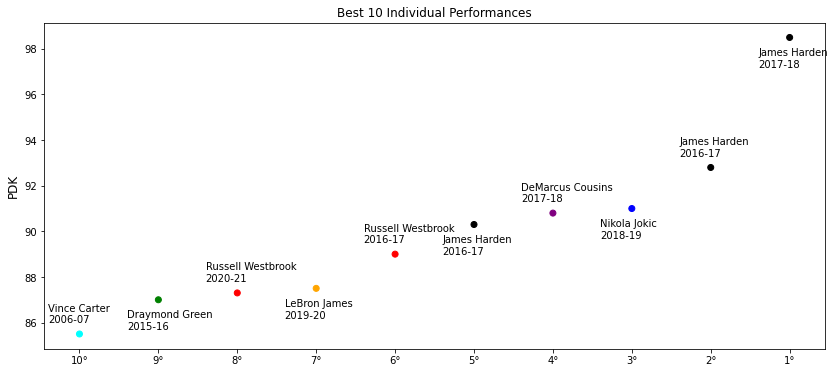

In [15]:
plot = best[['NAME', 'SEASON', 'PDK']].sort_values('PDK')
colors = {'Russell Westbrook': 'red', 'James Harden': 'black', 'Nikola Jokic': 'blue', 'Draymond Green': 'green', 'LeBron James': 'orange', 'Vince Carter': 'cyan', 'DeMarcus Cousins': 'purple'}

fig, ax = plt.subplots(figsize=(14, 6))
ax.scatter(np.arange(10), plot.PDK, c=plot.NAME.map(colors))

data = {}
idx = 0
for i in range(len(plot.SEASON)):
    if plot.SEASON.tolist()[i] not in data.keys():
        data[plot.SEASON.tolist()[i]] = idx
        idx += 1

for i in range(10):
    if i % 2 != 0:
        ax.annotate(f'{plot.NAME.tolist()[i]}\n{plot.SEASON.tolist()[i]}', (i - 0.4, plot.PDK.tolist()[i] - 1.3), clip_on=False)
    else:
        ax.annotate(f'{plot.NAME.tolist()[i]}\n{plot.SEASON.tolist()[i]}', (i - 0.4, plot.PDK.tolist()[i] + 0.5), clip_on=False)
        
plt.xticks([x for x in range(10)], [f'{10-x}°' for x in range(10)])
plt.title('Best 10 Individual Performances')
plt.ylabel('PDK', fontsize=12)
plt.show()

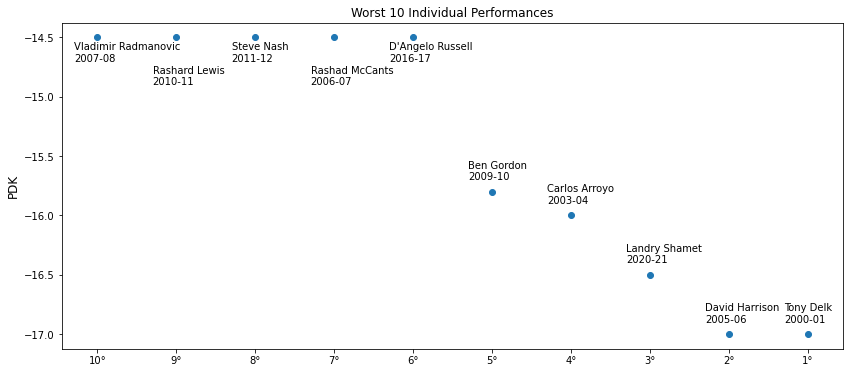

In [16]:
plot = worst[['NAME', 'SEASON', 'PDK']].sort_values('PDK', ascending=False)

fig, ax = plt.subplots(figsize=(14, 6))
ax.scatter(np.arange(10), plot.PDK)

data = {}
idx = 0
for i in range(len(plot.SEASON)):
    if plot.SEASON.tolist()[i] not in data.keys():
        data[plot.SEASON.tolist()[i]] = idx
        idx += 1

for i in range(10):
    if i < 5:
        if i % 2 == 0:
            ax.annotate(f'{plot.NAME.tolist()[i]}\n{plot.SEASON.tolist()[i]}', (i - 0.3, plot.PDK.tolist()[i] - 0.2), clip_on=False)
        else:
            ax.annotate(f'{plot.NAME.tolist()[i]}\n{plot.SEASON.tolist()[i]}', (i - 0.3, plot.PDK.tolist()[i] - 0.4), clip_on=False)
    else:
        ax.annotate(f'{plot.NAME.tolist()[i]}\n{plot.SEASON.tolist()[i]}', (i - 0.3, plot.PDK.tolist()[i] + 0.1), clip_on=False)

plt.xticks([x for x in range(10)], [f'{10-x}°' for x in range(10)])
plt.title('Worst 10 Individual Performances')
plt.ylabel('PDK', fontsize=12)
plt.show()

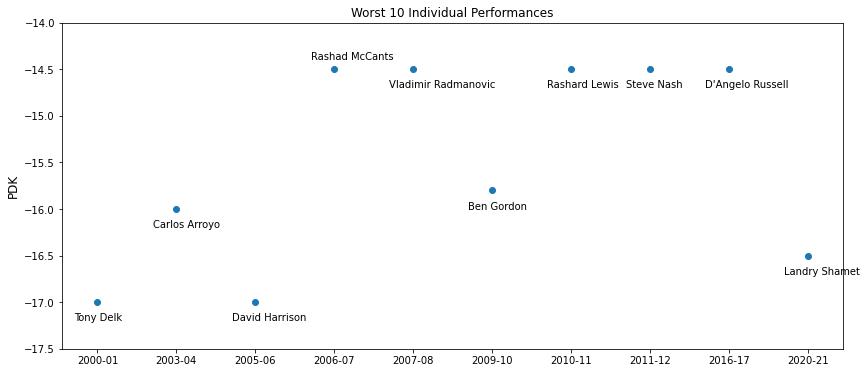

In [17]:
plot = worst[['NAME', 'SEASON', 'PDK']].sort_values('SEASON')

fig, ax = plt.subplots(figsize=(14, 6))
ax.scatter(plot.SEASON, plot.PDK)

data = {}
idx = 0
for i in range(len(plot.SEASON)):
    if plot.SEASON.tolist()[i] not in data.keys():
        data[plot.SEASON.tolist()[i]] = idx
        idx += 1

for i in range(10):
    if plot.NAME.tolist()[i] != 'Rashad McCants':
        ax.annotate(plot.NAME.tolist()[i], (data[plot.SEASON.tolist()[i]] - 0.3, plot.PDK.tolist()[i] - 0.2), clip_on=False)
    else:
        ax.annotate(plot.NAME.tolist()[i], (data[plot.SEASON.tolist()[i]] - 0.3, plot.PDK.tolist()[i] + 0.1), clip_on=False)

plt.ylim(-17.5, -14)
plt.title('Worst 10 Individual Performances')
plt.ylabel('PDK', fontsize=12)
plt.show()

## Player with highest total points per season

In [18]:
with open(f'{DATA_DIR}/players.pkl', 'rb') as fp:
    players = pickle.load(fp)
    
player = 'Kobe Bryant'

In [19]:
temp = df.groupby(['NAME', 'SEASON']).sum().reset_index()

In [20]:
best = temp.sort_values('PDK', ascending=False)[['NAME', 'SEASON', 'PDK']].head(10)

# Graph of PDK over time for a player

TODO: MAKE IT IN PERCENTAGES!

In [21]:
def hist_PDK(player, remove_non_played=False):
    player_df = df.loc[df.NAME == player]
    
    if remove_non_played:
        filt_1 = df.MP.str.contains('Dress')
        filt_2 = df.MP.str.contains('Suspended')
        player_df = player_df.loc[~filt_1]
        player_df = player_df.loc[~filt_2]
        
    n_games = player_df.shape[0]

    fig = plt.figure(figsize=(12, 6))
    
    plt.hist(player_df.PDK, bins=[x for x in range(-10, 100, 2)], edgecolor='black', label=player, weights=np.ones(n_games) / n_games)
    plt.axvline(player_df.PDK.mean(), label=f'mean: {round(player_df.PDK.mean(), 1)}', linestyle='--', color='red')
    # plt.axvline(player_df.PDK.median(), label=f'median: {round(player_df.PDK.median(), 1)}', linestyle='--', color='yellow')

    if remove_non_played:
        plt.xlabel('PDK, removed games not played!', fontsize=12)
    else:
        plt.xlabel('PDK, considering games not played!', fontsize=12)
        
    plt.ylabel(f'Percentage of games with that PDK', fontsize=12)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.legend(fontsize=12)
    plt.show()

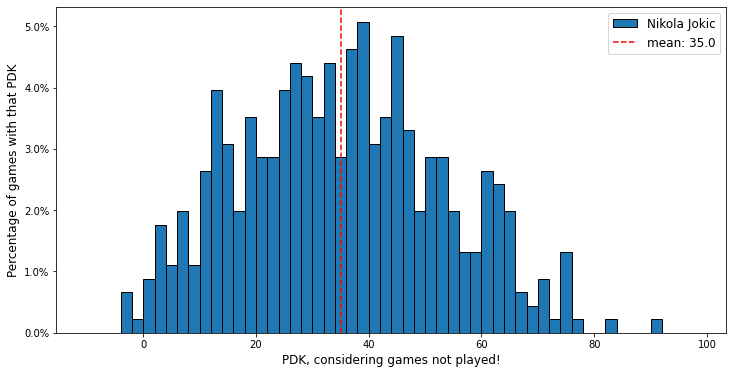

In [24]:
player = "Nikola Jokic"

hist_PDK(player, remove_non_played=False)

In [37]:
def hist_PDK_comparison(player_1, player_2, remove_non_played=False):
    player_df_1 = df.loc[df.NAME == player_1]
    player_df_2 = df.loc[df.NAME == player_2]
    
    if remove_non_played:
        filt_1 = df.MP.str.contains('Dress')
        filt_2 = df.MP.str.contains('Suspended')
        player_df_1 = player_df_1.loc[~filt_1]
        player_df_1 = player_df_1.loc[~filt_2]
        player_df_2 = player_df_2.loc[~filt_1]
        player_df_2 = player_df_2.loc[~filt_2]
    
    n_games_1 = player_df_1.shape[0]
    n_games_2 = player_df_2.shape[0]

    fig = plt.figure(figsize=(12, 6))

    plt.hist(player_df_1.PDK, bins=[x for x in range(-10, 100, 2)], edgecolor='black', label=player_1, weights=np.ones(n_games_1) / n_games_1)    
    plt.hist(player_df_2.PDK, bins=[x for x in range(-10, 100, 2)], edgecolor='black', label=player_2, alpha=0.85, weights=np.ones(n_games_2) / n_games_2)
    
    plt.axvline(player_df_1.PDK.mean(), label=f'mean {player_1}: {round(player_df_1.PDK.mean(), 1)}', linestyle='--', color='blue')
    plt.axvline(player_df_2.PDK.mean(), label=f'mean {player_2}: {round(player_df_2.PDK.mean(), 1)}', linestyle='--', color='orange')

    if remove_non_played:
        plt.xlabel('PDK, removed games not played!', fontsize=12)
    else:
        plt.xlabel('PDK, considering games not played!', fontsize=12)
        
    plt.ylabel(f'Percentage of games with that PDK', fontsize=12)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.legend(fontsize=12)
    plt.show()

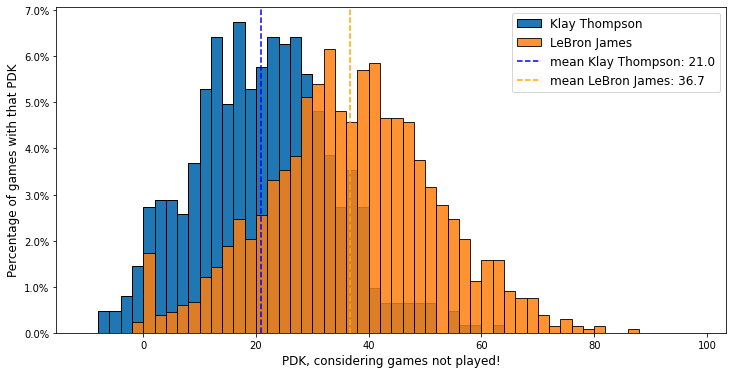

In [42]:
hist_PDK_comparison(player_1="Klay Thompson", player_2='LeBron James')

# TEST

In [26]:
temp = df.loc[df.DATE.str.contains('2020')]

temp = temp.sort_values('PDK', ascending=False)

In [27]:
row

,NAME,POS,DATE,SEASON,TEAM,HOME,W,W_PTS,L,L_PTS,MP,FG,FGA,FG_perc,3P,3PA,3P_perc,FT,FTA,FT_perc,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,+/-,TS_perc,eFG_perc,3PAr,FTr,ORB_perc,DRB_perc,TRB_perc,AST_perc,STL_perc,BLK_perc,TOV_perc,USG_perc,ORtg,DRtg,BPM,ST,BA,SEASON.1,PDK
610640,Draymond Green,F,2017-02-10,2016-17,GSW,0,GSW,122,MEM,107,37:44,2,6,0.333,0,3,0.0,0,0,NaN,0,11,11,10,10,5,2,3,10,26.0,0.333,0.333,0.5,0.0,0.0,29.8,17.3,34.9,13.0,10.4,25.0,9.6,106.0,76.0,19.3,1.0,1,2016-17,64.0


In [28]:
row = temp.iloc[0]

get_player_score(row)

134.8

# What is the player with the highest average?

In [29]:
_, _, player_dataframes = next(os.walk(f'{DATA_DIR}/Players'))

best_pdk = 0.0

for dataframe in player_dataframes:
    df = pd.read_csv(f'{DATA_DIR}/Players/{dataframe}')
    if df.PDK.max() > best_pdk:
        best_pdk = df.PDK.max()
        best_player = df.index.tolist()[0]
    elif df.PDK.max() == best_pdk:
        best_pdk = list(best_pdk).append(pd.PDK.max())
        best_player = list(best_player).append(df.index.tolist()[0])


In [30]:
best_pdk, best_player

(98.5, 24053)

# Doublecheck and add to data collection!


In [31]:
df

,NAME,POS,DATE,SEASON,TEAM,HOME,W,W_PTS,L,L_PTS,MP,FG,FGA,FG_perc,3P,3PA,3P_perc,FT,FTA,FT_perc,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,+/-,TS_perc,eFG_perc,3PAr,FTr,ORB_perc,DRB_perc,TRB_perc,AST_perc,STL_perc,BLK_perc,TOV_perc,USG_perc,ORtg,DRtg,BPM,ST,BA,SEASON.1,PDK
13872,Reggie Miller,G,1996-11-01,1996-97,IND,0,DET,95,IND,89,40:37,4,15,0.267,2,8,0.250,7,7,1.000,1,3,4,6,0,2,3,2,17,-8.0,0.470,0.333,0.533,0.467,3.1,9.5,6.2,24.8,0.0,4.9,14.2,24.2,101.0,110.0,2.6,1.0,0,1996-97,15.8
20955,Reggie Miller,G,1996-11-02,1996-97,IND,1,MIA,97,IND,95,39:07,11,22,0.500,3,6,0.500,9,11,0.818,0,4,4,3,1,1,4,2,34,6.0,0.633,0.568,0.273,0.500,0.0,13.3,6.7,21.1,1.3,2.7,13.0,35.2,117.0,102.0,9.4,1.0,1,1996-97,27.0
2679,Reggie Miller,G,1996-11-06,1996-97,IND,0,BOS,94,IND,84,37:13,9,21,0.429,4,10,0.400,6,7,0.857,2,3,5,3,0,0,2,3,28,-5.0,0.581,0.524,0.476,0.333,6.7,9.7,8.2,18.3,0.0,0.0,7.7,32.9,126.0,111.0,5.1,1.0,0,1996-97,24.0
20730,Reggie Miller,G,1996-11-09,1996-97,IND,1,IND,103,WSB,100,42:00,5,17,0.294,0,3,0.000,6,6,1.000,1,5,6,6,0,1,3,2,16,5.0,0.407,0.294,0.176,0.353,2.9,12.4,8.0,23.2,0.0,1.7,13.3,24.4,92.0,101.0,-1.9,1.0,3,1996-97,18.8
5848,Reggie Miller,G,1996-11-12,1996-97,IND,0,DAL,103,IND,82,21:53,7,13,0.538,3,5,0.600,2,4,0.500,1,1,2,1,0,1,1,1,19,-20.0,0.644,0.654,0.385,0.308,4.1,5.3,4.6,15.9,0.0,3.4,6.3,30.7,121.0,115.0,13.6,1.0,1,1996-97,15.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10714,Reggie Miller,G,2005-04-13,2004-05,IND,1,IND,90,NJN,86,34:18,7,16,0.438,3,7,0.429,5,5,1.000,2,5,7,2,3,0,0,1,22,4.0,0.604,0.531,0.438,0.313,5.8,19.1,11.6,15.5,5.0,0.0,0.0,26.0,136.0,94.0,15.8,1.0,1,2004-05,34.5
3088,Reggie Miller,G,2005-04-15,2004-05,IND,1,PHI,90,IND,86,39:13,4,16,0.250,1,9,0.111,4,6,0.667,0,3,3,2,1,0,2,0,13,-12.0,0.349,0.281,0.563,0.375,0.0,10.2,4.5,11.0,1.4,0.0,9.7,24.7,72.0,101.0,-7.3,1.0,0,2004-05,1.5
2677,Reggie Miller,G,2005-04-17,2004-05,IND,0,MIA,84,IND,80,30:44,5,11,0.455,2,5,0.400,6,6,1.000,0,1,1,2,0,0,2,1,18,-4.0,0.660,0.545,0.455,0.545,0.0,4.4,2.0,17.8,0.0,0.0,12.8,25.8,124.0,111.0,6.9,1.0,0,2004-05,11.0
6829,Reggie Miller,G,2005-04-18,2004-05,IND,0,ORL,92,IND,88,36:06,5,13,0.385,1,6,0.167,2,3,0.667,0,2,2,4,1,0,1,2,13,1.0,0.454,0.423,0.462,0.231,0.0,7.2,3.3,21.9,1.6,0.0,6.5,20.6,103.0,111.0,-1.6,1.0,0,2004-05,10.0


In [32]:
import os
import time
from tqdm import notebook
from collections import defaultdict
from datetime import datetime
from dateutil import parser

import pandas as pd
import numpy as np
from urllib.request import urlopen
import requests
from bs4 import BeautifulSoup

from constants import DATA_DIR, SEASONS

SLEEP_TIME = 1

NAMES_CONVERSION = {'ć': 'c', 'č': 'c', 'Č': 'C', 'ç': 'c',
                    'ã': 'a', 'ā': 'a', 'á': 'a', 'ä': 'a', 'Á': 'A',
                    'ž': 'z',
                    'í': 'i', 'İ': 'I', 'ï': 'i', 'ı': 'i',
                    'ö': 'o', 'ó': 'o', 'ò': 'o', 'ô': 'o', 'Ó': 'O', 'Ö': 'O',
                    'é': 'e', 'ê': 'e', 'ë': 'e', 'è': 'e',
                    'Š': 'S', 'ș': 's', 'š': 's', 'ş': 's',
                    'ū': 'u', 'ü': 'u', 'ú': 'u',
                    'ņ': 'n', 'ń': 'n',
                    'ģ': 'g', 'ğ': 'g',
                    'ý': 'y',
                    'Ž': 'Z',
                    'ř': 'r',
                   }

In [33]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Check if there are two players with the same name

In [34]:
def check_duplicates(season):
    df = pd.read_csv(f'{DATA_DIR}/Boxscores/{season}.csv')
    
    columns = ['NAME', 'DATE', 'TEAM']
    temp = df[columns].drop_duplicates()
    diff = df.shape[0] - temp.shape[0]
    print(f'There {"is" if diff==1 else "are"} {"no" if diff==0 else diff} {"row" if diff==1 else "rows"} with the same {[col for col in columns]}.')
    if diff > 0:
        return df[df.duplicated(subset=columns)]
    else:
        return None


In [35]:
check_duplicates(season='2020-21')

There are no rows with the same ['NAME', 'DATE', 'TEAM'].


## Merge dunkest and boxscore (only for season 2020-21)

In [36]:
dunkest_df = pd.read_csv(f'{DATA_DIR}/Credits/2020-21/2020-21.csv')
boxscore_df = pd.read_csv(f'{DATA_DIR}/Boxscores/2006-07.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/home/filipo/Documents/dunkest_project/data/Credits/2020-21/2020-21.csv'

In [ ]:
boxscore_df

#### 1) Define which columns to keep

In [ ]:
columns_keep_boxscore = ['NAME', 'DATE', 'TEAM', 'HOME', 'W', 'W_PTS', 'L', 'L_PTS', 'MP',
                         'FG', 'FGA', 'FG_perc', '3P', '3PA', '3P_perc', 'FT', 'FTA', 'FT_perc', 
                         'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', '+-', 
                         'TS_perc', 'eFG_perc', '3PAr', 'FTr', 'ORB_perc', 'DRB_perc', 'TRB_perc', 
                         'AST_perc', 'STL_perc', 'BLK_perc', 'TOV_perc', 'USG_perc', 'ORtg', 'DRtg', 
                         'BPM', 'BA']


columns_keep_dunkest = ['NAME', 'POS', 'TEAM', 'PDK', 'CR', 'PLUS', 'GP', 'WEEK', 'PTS', 'AST', 'BLK', 'STL']

#### 1.1) change boxscored_df 'BLK_suff' name

In [ ]:
boxscore_df.rename(columns={'BLK_suff': 'BA'}, inplace=True)

#### 2) remove rows where the player did not play from boxscore_df

In [ ]:
boxscore_df = boxscore_df.loc[~boxscore_df['MP'].isin(['0:00', 'Did Not Dress'])]

#### 3) Remove last part of the name from dunkest

In [ ]:
def adjust_name(name):
    """
    We don't want any punctuation or any 3rd name!
    """
    # remove 3rd name
    first, second = name.split(' ')[:2]
    
    first = first.replace('.', '')
    second = second.replace('.', '')
    
    return ' '.join([first, second])

In [ ]:
print(f'Before changes we have {len(dunkest_df.NAME.unique())} names in dunkest_df.\n')

dunkest_df['NAME'] = dunkest_df['NAME'].apply(adjust_name)

print(f'After changes we have {len(dunkest_df.NAME.unique())} names in dunkest_df.')

In [ ]:
print(f'Before changes we have {len(boxscore_df.NAME.unique())} names in dunkest_df.\n')

boxscore_df['NAME'] = boxscore_df['NAME'].apply(adjust_name)

print(f'After changes we have {len(boxscore_df.NAME.unique())} names in dunkest_df.')

#### 4) fix different names

In [ ]:
def adjust_different_names(name):
    changes_in_boxscore = {'Mohamed Bamba': 'Mo Bamba', 
                       'Nicolas Claxton': 'Nic Claxton', 
                       'Wesley Iwundu': 'Wes Iwundu',
                       'Juan Hernangomez': 'Juancho Hernangomez'}
    
    try:
        new_name = changes_in_boxscore[name]
        return new_name
    except KeyError:
        return name

In [ ]:
boxscore_df['NAME'] = boxscore_df['NAME'].apply(adjust_different_names)

In [ ]:
in_boxscore_not_dunkest = set()
for name in boxscore_df.NAME.unique():
    if name not in dunkest_df.NAME.unique():
        in_boxscore_not_dunkest.add(name)
        
in_dunkest_not_boxscore = set()
for name in dunkest_df.NAME.unique():
    if name not in boxscore_df.NAME.unique():
        in_dunkest_not_boxscore.add(name)

In [ ]:
boxscore_df.loc[boxscore_df['NAME'].isin(in_boxscore_not_dunkest)].sort_values('MP', ascending=False).head(5)

In [ ]:
dunkest_df.loc[dunkest_df['NAME'].isin(in_dunkest_not_boxscore)]

*Osservation:* each name in the two lists did not play significant minutes ever, thus they can also be removed.

# 5) Merge on [NAME, TEAM]

In [ ]:
boxscore_df_to_merge = boxscore_df[columns_keep_boxscore]
dunkest_df_to_merge = dunkest_df[columns_keep_dunkest]

In [ ]:
boxscore_test = boxscore_df_to_merge.loc[boxscore_df_to_merge['NAME']=='Buddy Hield']
dunkest_test = dunkest_df_to_merge.loc[dunkest_df_to_merge['NAME']=='Buddy Hield']

**Idea:** compute score for each game of the player and then merge on that!